## Problem Statement
A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.

The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

The company wants to know:

Which variables are significant in predicting the price of a house, and

How well those variables describe the price of a house.

Also, determine the optimal value of lambda for ridge and lasso regression.

## Business Goal
You are required to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.



In [428]:
# Import Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import GridSearchCV
import scipy.stats as stats

import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

### Data Understanding and Preparation

In [429]:
# Load Dataset
housing_dataset = pd.read_csv("train.csv")

In [430]:
# Preview Dataset
housing_dataset.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [431]:
# Dataset Info
housing_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Handling Null Values

In [432]:
# Find the amount of null values present in the columns
round(housing_dataset.isnull().sum()/len(housing_dataset.index),2).sort_values(ascending=False).head(15)


PoolQC          1.00
MiscFeature     0.96
Alley           0.94
Fence           0.81
FireplaceQu     0.47
LotFrontage     0.18
GarageYrBlt     0.06
GarageFinish    0.06
GarageType      0.06
GarageQual      0.06
GarageCond      0.06
BsmtExposure    0.03
BsmtQual        0.03
BsmtCond        0.03
BsmtFinType2    0.03
dtype: float64

#### Drop columns with more than 80 percent missing values

In [433]:
#Dropping PoolQC, MiscFeature, Alley, Fence
housing_df = housing_dataset.drop(columns=['Alley', 'PoolQC', 'MiscFeature', 'Fence'])

In [434]:
# Find percentage of null values in remaining null values
housing_df.isnull().sum()[housing_df.isnull().sum()>0]

LotFrontage     259
MasVnrType        8
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
FireplaceQu     690
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64

In [435]:
numerical_null_columns = ['LotFrontage', 'MasVnrArea']
categorical_null_columns = ['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType','GarageYrBlt'
                           'GarageFinish', 'GarageQual', 'GarageCond']

In [436]:
# Fill Na in Numerical columns with median value
housing_df['LotFrontage'] = housing_df['LotFrontage'].fillna(housing_df['LotFrontage'].median())


In [437]:
# Fill Na in Numerical columns with median value
housing_df['MasVnrArea'] = housing_df['MasVnrArea'].fillna(housing_df['MasVnrArea'].median())

In [438]:
housing_df['BsmtQual'] = housing_df['BsmtQual'].fillna('No_Basement')

In [439]:
housing_df['BsmtCond'] = housing_df['BsmtCond'].fillna('No_Basement')

In [440]:
housing_df['BsmtExposure'] = housing_df['BsmtExposure'].fillna('No_Basement')

In [441]:
housing_df['BsmtFinType1'] = housing_df['BsmtFinType1'].fillna('No_Basement')

In [442]:
housing_df['BsmtFinType2'] = housing_df['BsmtFinType2'].fillna('No_Basement')

In [443]:
housing_df['FireplaceQu'] = housing_df['FireplaceQu'].fillna('No_Fireplace')

In [444]:
housing_df['GarageType'] = housing_df['GarageType'].fillna('No_Garage')

In [445]:
housing_df['GarageYrBlt'] = housing_df['GarageYrBlt'].fillna(0)

In [446]:
housing_df['GarageFinish'] = housing_df['GarageFinish'].fillna('No_Garage')

In [447]:
housing_df['GarageQual'] = housing_df['GarageQual'].fillna('No_Garage')

In [448]:
housing_df['GarageCond'] = housing_df['GarageCond'].fillna('No_Garage')

In [449]:
housing_df['MasVnrType'] = housing_df['MasVnrType'].fillna('None')

In [450]:
# replace null with mode, since only 1 value is missing
housing_df['Electrical'] = housing_df['Electrical'].fillna(housing_df['Electrical'].mode()[0])

In [451]:
#check if there are any more columns with null values
housing_df.isnull().sum()[housing_df.isnull().sum()>0]

Series([], dtype: int64)

### Check if new data columns can be derived

In [452]:
#calculate the age of house i.e. HouseAge from YrSold - YearBuilt 
housing_df['HouseAge'] = housing_df.YrSold - housing_df.YearBuilt

In [453]:
#calculate the age of garage i.e. HouseAge from YrSold - YearBuilt 
housing_df['GarageAge'] = housing_df.YrSold - housing_df.GarageYrBlt

In [454]:
#calculate the age of house i.e. HouseAge from YrSold - YearBuilt 
housing_df['HouseModifiedAge'] = housing_df.YrSold - housing_df.YearRemodAdd

In [455]:
#Dropping YrSold, YearBuilt, YearRemodAdd, MoSold after HouseAge, 
housing_df=housing_df.drop(columns=['YrSold', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd', 'MoSold'])

In [456]:
# Combine OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch
housing_df['TotalPorchArea'] = housing_df.OpenPorchSF + housing_df.EnclosedPorch + housing_df['3SsnPorch'] +housing_df.ScreenPorch 

In [457]:
#Dropping OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch
housing_df=housing_df.drop(columns=['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'])

In [458]:
#Calculate Total house built up area
housing_df['Total_sqr_footage'] = (housing_df['BsmtFinSF1'] + housing_df['BsmtFinSF2'] + housing_df['1stFlrSF'] + housing_df['2ndFlrSF'])

In [459]:
# Drop BsmtFinSF1, BsmtFinSF2, 1stFlrSF, 2ndFlrSF
housing_df=housing_df.drop(columns=['BsmtFinSF1', 'BsmtFinSF2', '1stFlrSF', '2ndFlrSF'])

In [460]:
# Calculating Total number of bathrooms
housing_df['Total_Bathrooms'] = (housing_df['FullBath'] + (0.5 * housing_df['HalfBath']) + housing_df['BsmtFullBath'] + (0.5 * housing_df['BsmtHalfBath']))

In [461]:
# Drop FullBath, HalfBath, BsmtFullBath, BsmtHalfBath
housing_df=housing_df.drop(columns=['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'])

In [462]:
# Drop Id Column as it not significant in analysis
housing_df= housing_df.drop(columns=['Id'])

In [463]:

# convert OverallQual, MSSubClass, OverallCond into object type 
convert_dict = {'MSSubClass':object}
housing_df = housing_df.astype(convert_dict)
convert_dict = {'OverallQual':object}
housing_df = housing_df.astype(convert_dict)
convert_dict = {'OverallCond':object}
housing_df = housing_df.astype(convert_dict)


In [464]:
housing_df.shape

(1460, 65)

In [465]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 65 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MSSubClass         1460 non-null   object 
 1   MSZoning           1460 non-null   object 
 2   LotFrontage        1460 non-null   float64
 3   LotArea            1460 non-null   int64  
 4   Street             1460 non-null   object 
 5   LotShape           1460 non-null   object 
 6   LandContour        1460 non-null   object 
 7   Utilities          1460 non-null   object 
 8   LotConfig          1460 non-null   object 
 9   LandSlope          1460 non-null   object 
 10  Neighborhood       1460 non-null   object 
 11  Condition1         1460 non-null   object 
 12  Condition2         1460 non-null   object 
 13  BldgType           1460 non-null   object 
 14  HouseStyle         1460 non-null   object 
 15  OverallQual        1460 non-null   object 
 16  OverallCond        1460 

### Find Relationship between Predictor and Target Variable [Data Visualization]

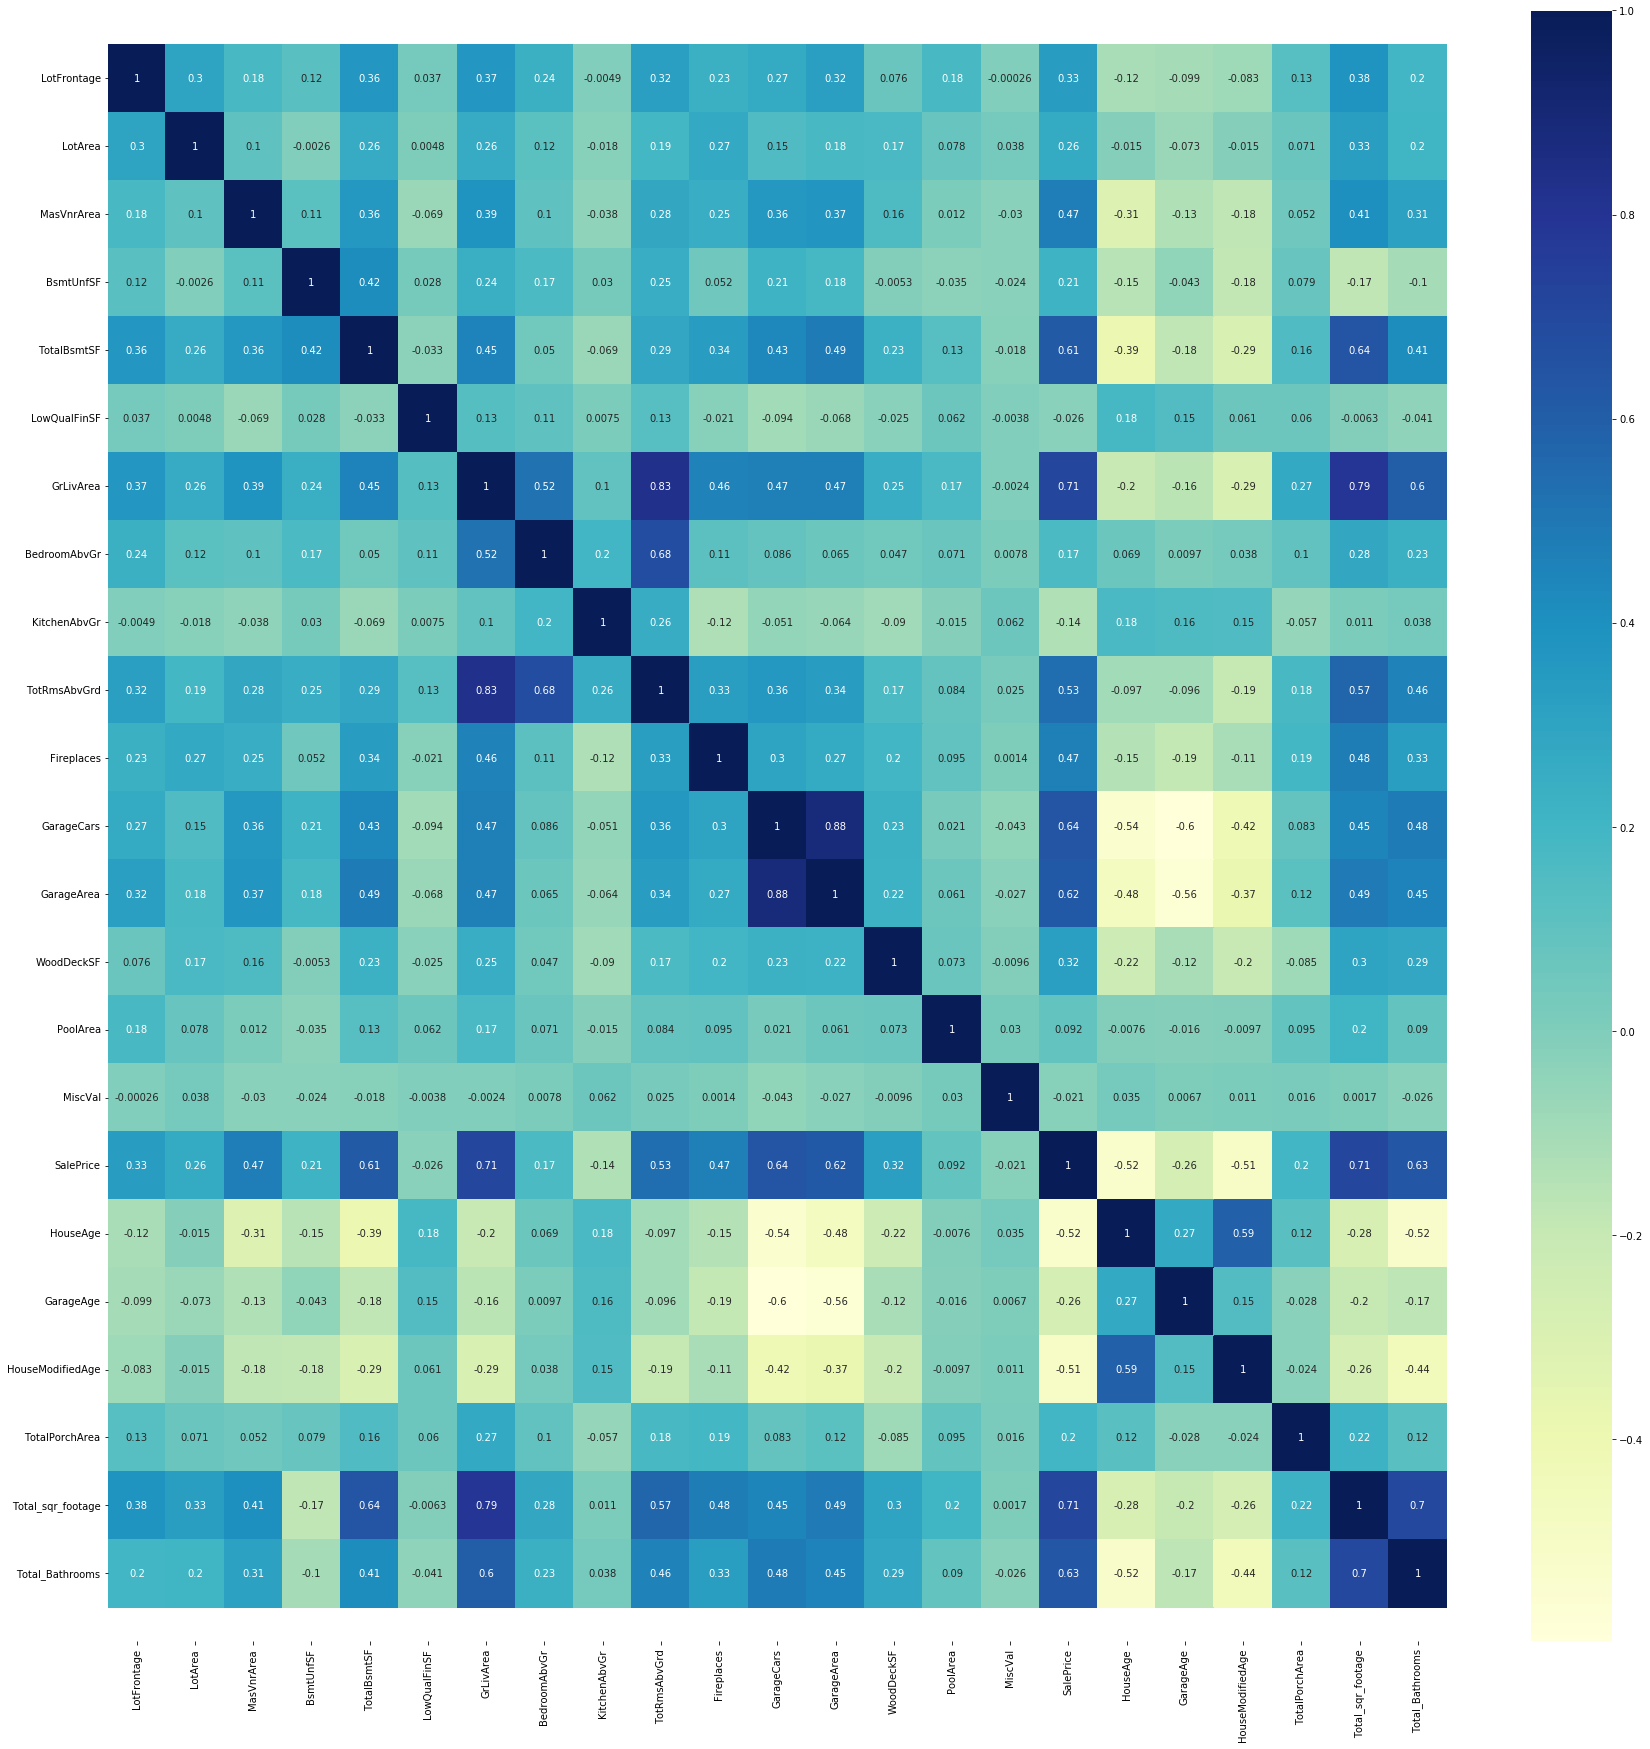

In [466]:
# Plot Correlation metrics
f, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(housing_df.corr(), 
            xticklabels=housing_df.corr().columns.values,
            yticklabels=housing_df.corr().columns.values,annot= True,
            cmap="YlGnBu")

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

In [467]:
corr_val = housing_df[list(housing_df.dtypes[housing_df.dtypes != 'object'].index)].corr()

In [468]:
#Find Top Correlated Columns
corr_coef = corr_val[corr_val['SalePrice'] > 0.5]['SalePrice'].sort_values(ascending=False)
print(corr_coef[1:])
corr_coef_cols = [idx for idx in corr_coef.index]

GrLivArea            0.708624
Total_sqr_footage    0.708047
GarageCars           0.640409
Total_Bathrooms      0.631731
GarageArea           0.623431
TotalBsmtSF          0.613581
TotRmsAbvGrd         0.533723
Name: SalePrice, dtype: float64


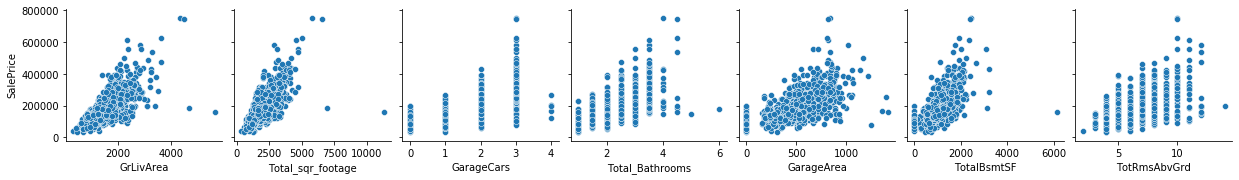

In [469]:

sns.pairplot(housing_df, x_vars=corr_coef_cols[1:], y_vars=[corr_coef_cols[0]])
plt.show()

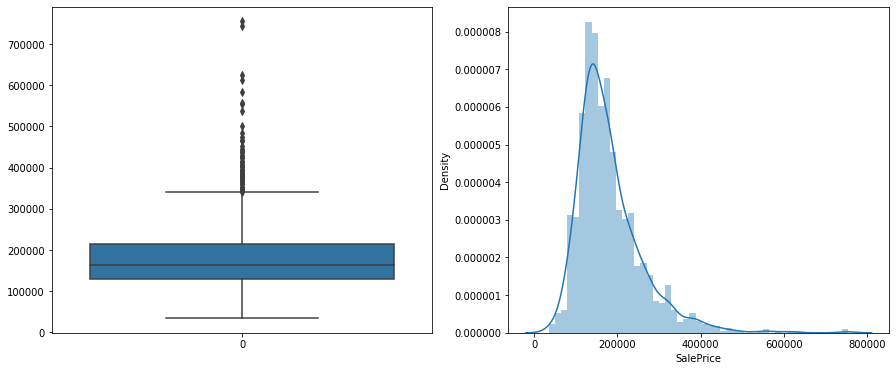

In [470]:
# Let us check the SalePrice as well
f, axes = plt.subplots(1, 2, figsize=(15,6))
sns.boxplot(housing_df['SalePrice'],  orient='v' , ax=axes[0])
sns.distplot(housing_df['SalePrice'], ax=axes[1])
plt.show()



In [471]:


#skewness and kurtosis
print("Skewness: %f" % housing_df['SalePrice'].skew())

Skewness: 1.882876


#### We infer Sales price is right skewed from the above observation.

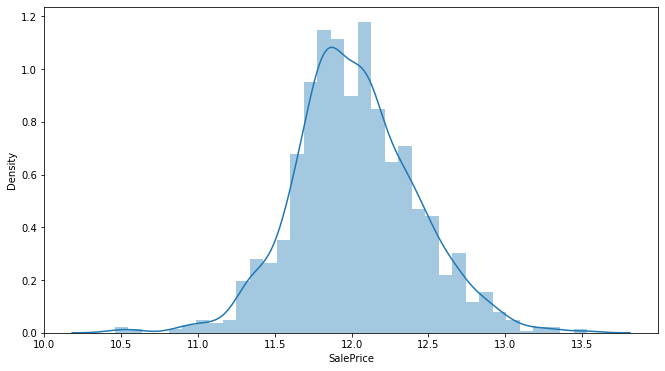

In [472]:
plt.figure(figsize=(11,6))
sns.distplot(np.log(housing_df["SalePrice"]))

In [473]:
housing_df['SalePrice'] = np.log(housing_df.SalePrice)

In [474]:
#skewness 
print("Skewness of SalePrice after log transform: %f" % housing_df['SalePrice'].skew())

Skewness of SalePrice after log transform: 0.121335


#### Now Sales price is normalised after log transformation

In [475]:
#List of Categorical Columns
categorical_columns = [f for f in housing_df.columns if housing_df.dtypes[f] == 'object']

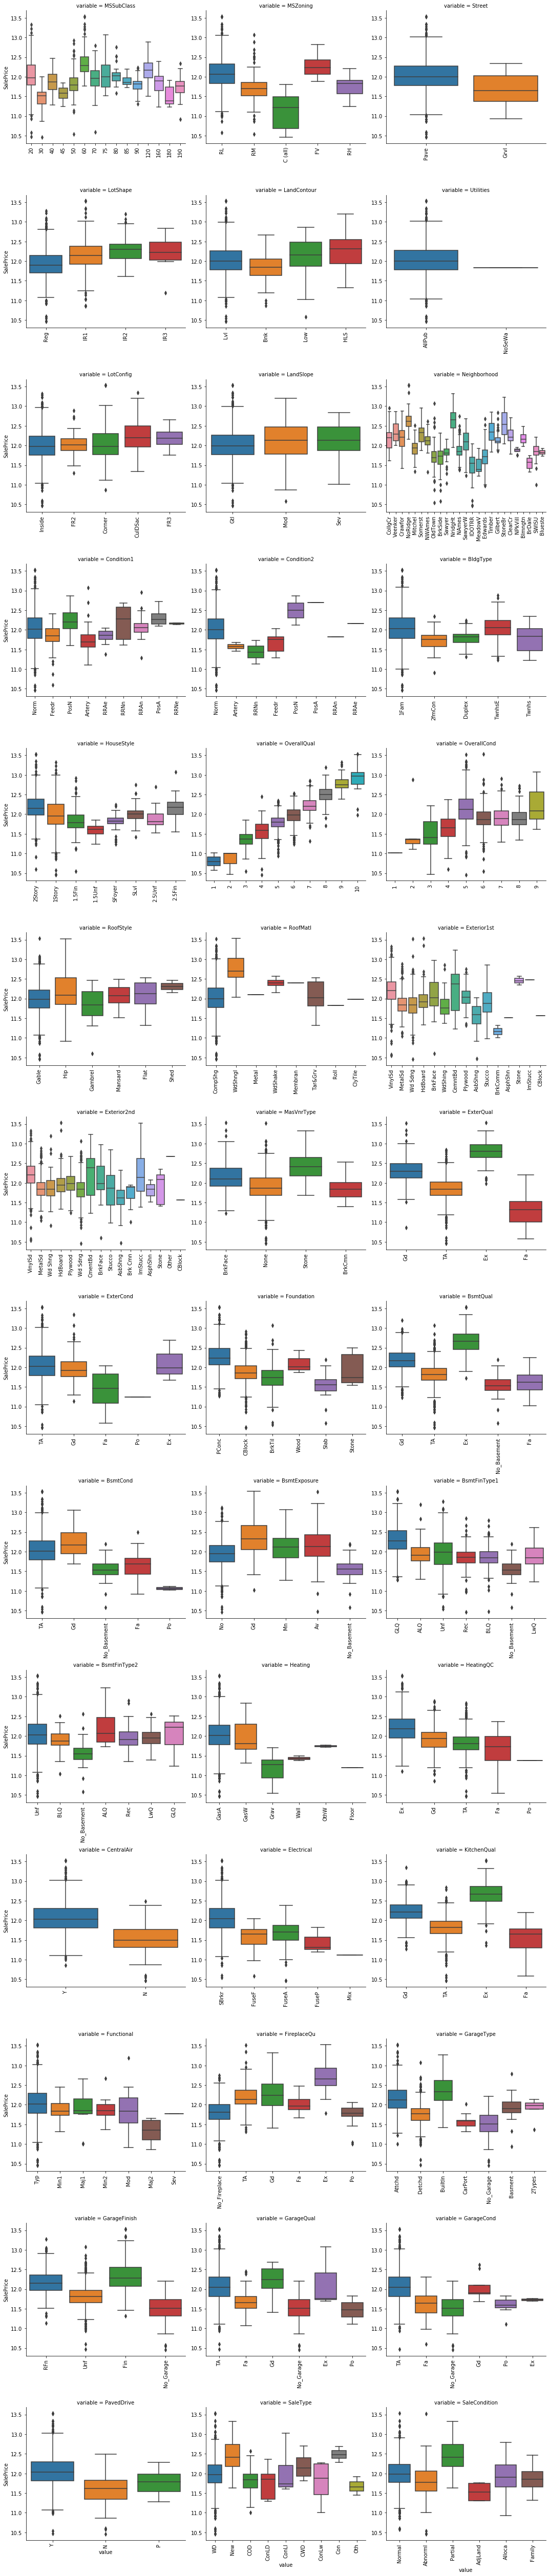

In [476]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
    
f = pd.melt(housing_df, id_vars=['SalePrice'], value_vars=categorical_columns)
g = sns.FacetGrid(f, col="variable",col_wrap=3, sharex=False, sharey=False, height=5)
g = g.map(boxplot, "value", "SalePrice")


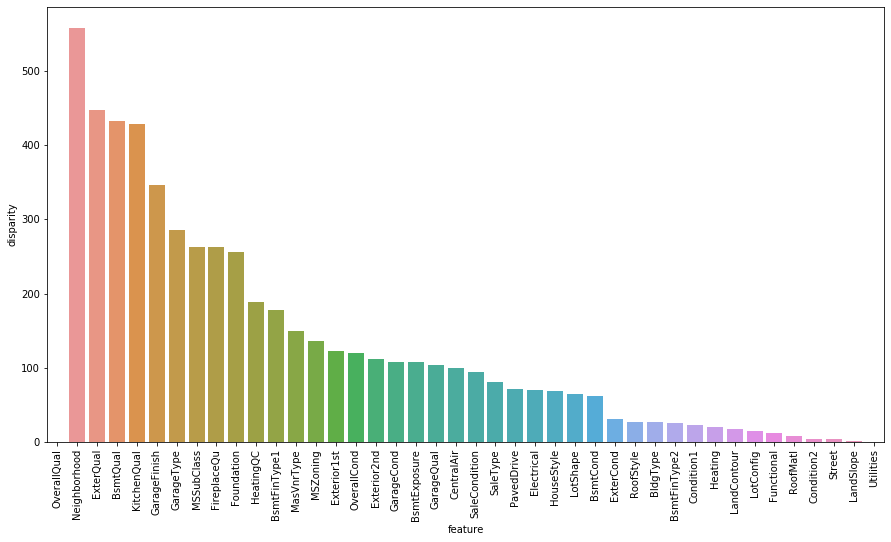

In [477]:
def create_chart_with_sales(frame):
    anv = pd.DataFrame()
    anv['feature'] = categorical_columns
    pvals = []
    for category in categorical_columns:
        samples = []
        for cls in frame[category].unique():
            s = frame[frame[category] == cls]['SalePrice'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = create_chart_with_sales(housing_df)
a['disparity'] = np.log(1./a['pval'].values)
plt.figure(figsize=(15,8))
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)

From the above chart we can see that some of the majorly influencing variables are -
- OverallQuality
- Neigbhourhood
- External Quality
- Basement Quality
- KitchenQuality

In [478]:
# Removing bottom 5 predictors with least correlation
housing_df.drop(columns= ['Utilities',  'RoofMatl', 'Condition2','Street', 'LandSlope'], inplace=True)

In [479]:
housing_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,...,MiscVal,SaleType,SaleCondition,SalePrice,HouseAge,GarageAge,HouseModifiedAge,TotalPorchArea,Total_sqr_footage,Total_Bathrooms
0,60,RL,65.0,8450,Reg,Lvl,Inside,CollgCr,Norm,1Fam,...,0,WD,Normal,12.247694,5,5.0,5,61,2416,3.5
1,20,RL,80.0,9600,Reg,Lvl,FR2,Veenker,Feedr,1Fam,...,0,WD,Normal,12.109011,31,31.0,31,0,2240,2.5
2,60,RL,68.0,11250,IR1,Lvl,Inside,CollgCr,Norm,1Fam,...,0,WD,Normal,12.317167,7,7.0,6,42,2272,3.5
3,70,RL,60.0,9550,IR1,Lvl,Corner,Crawfor,Norm,1Fam,...,0,WD,Abnorml,11.849398,91,8.0,36,307,1933,2.0
4,60,RL,84.0,14260,IR1,Lvl,FR2,NoRidge,Norm,1Fam,...,0,WD,Normal,12.429216,8,8.0,8,84,2853,3.5


### Creating dummy variable for categorical variables

In [480]:
housing_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,...,MiscVal,SaleType,SaleCondition,SalePrice,HouseAge,GarageAge,HouseModifiedAge,TotalPorchArea,Total_sqr_footage,Total_Bathrooms
0,60,RL,65.0,8450,Reg,Lvl,Inside,CollgCr,Norm,1Fam,...,0,WD,Normal,12.247694,5,5.0,5,61,2416,3.5
1,20,RL,80.0,9600,Reg,Lvl,FR2,Veenker,Feedr,1Fam,...,0,WD,Normal,12.109011,31,31.0,31,0,2240,2.5
2,60,RL,68.0,11250,IR1,Lvl,Inside,CollgCr,Norm,1Fam,...,0,WD,Normal,12.317167,7,7.0,6,42,2272,3.5
3,70,RL,60.0,9550,IR1,Lvl,Corner,Crawfor,Norm,1Fam,...,0,WD,Abnorml,11.849398,91,8.0,36,307,1933,2.0
4,60,RL,84.0,14260,IR1,Lvl,FR2,NoRidge,Norm,1Fam,...,0,WD,Normal,12.429216,8,8.0,8,84,2853,3.5


In [481]:
housing_categorical = housing_df.select_dtypes('object')
housing_categorical.head()

,MSSubClass,MSZoning,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,60,RL,Reg,Lvl,Inside,CollgCr,Norm,1Fam,2Story,7,...,Gd,Typ,No_Fireplace,Attchd,RFn,TA,TA,Y,WD,Normal
1,20,RL,Reg,Lvl,FR2,Veenker,Feedr,1Fam,1Story,6,...,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
2,60,RL,IR1,Lvl,Inside,CollgCr,Norm,1Fam,2Story,7,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
3,70,RL,IR1,Lvl,Corner,Crawfor,Norm,1Fam,2Story,7,...,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,60,RL,IR1,Lvl,FR2,NoRidge,Norm,1Fam,2Story,8,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal


In [482]:
housing_dummies = pd.get_dummies(housing_categorical, drop_first=True)
housing_dummies.head()


,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [483]:
housing_df = housing_df.drop(list(housing_categorical.columns),axis=1)

In [484]:
housing_df = pd.concat([housing_df, housing_dummies], axis=1)

In [485]:
housing_df.head()

,LotFrontage,LotArea,MasVnrArea,BsmtUnfSF,TotalBsmtSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,196.0,150,856,0,1710,3,1,8,...,0,0,0,0,1,0,0,0,1,0
1,80.0,9600,0.0,284,1262,0,1262,3,1,6,...,0,0,0,0,1,0,0,0,1,0
2,68.0,11250,162.0,434,920,0,1786,3,1,6,...,0,0,0,0,1,0,0,0,1,0
3,60.0,9550,0.0,540,756,0,1717,3,1,7,...,0,0,0,0,1,0,0,0,0,0
4,84.0,14260,350.0,490,1145,0,2198,4,1,9,...,0,0,0,0,1,0,0,0,1,0


### Test Train Split

In [486]:
df_train,df_test = train_test_split(housing_df, train_size=0.7,test_size = 0.3, random_state=100)

In [487]:
y_train = df_train.SalePrice
X_train = df_train.drop("SalePrice",1)

y_test= df_test.SalePrice
X_test = df_test.drop("SalePrice",1)

In [488]:
print('X_train shape',X_train.shape)
print('X_test shape',X_test.shape)
print('y_train shape',y_train.shape)
print('y_test shape',y_test.shape)

X_train shape (1021, 245)
X_test shape (438, 245)
y_train shape (1021,)
y_test shape (438,)


### Scaling the continous variables

In [489]:
numerical_columns = [f for f in housing_df.columns if housing_df.dtypes[f] == 'int64' or housing_df.dtypes[f] == 'float64' or housing_df.dtypes[f] == 'int32' or housing_df.dtypes[f] == 'float32']

In [490]:
print(numerical_columns)

['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtUnfSF', 'TotalBsmtSF', 'LowQualFinSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'PoolArea', 'MiscVal', 'SalePrice', 'HouseAge', 'GarageAge', 'HouseModifiedAge', 'TotalPorchArea', 'Total_sqr_footage', 'Total_Bathrooms']


In [491]:
numerical_columns.remove('SalePrice')

In [492]:
#Scale numerical predictors using StandardScaler()
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

## Linear Regression

Let's now try predicting sales prices, a dataset using linear regression.

In [493]:
lm = LinearRegression()
rfe = RFE(lm, n_features_to_select=70)
rfe = rfe.fit(X_train, y_train)


In [494]:
# Find the top 70 features
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('LotFrontage', False, 147),
 ('LotArea', False, 126),
 ('MasVnrArea', False, 170),
 ('BsmtUnfSF', False, 56),
 ('TotalBsmtSF', False, 57),
 ('LowQualFinSF', False, 122),
 ('GrLivArea', True, 1),
 ('BedroomAbvGr', False, 140),
 ('KitchenAbvGr', False, 86),
 ('TotRmsAbvGrd', False, 162),
 ('Fireplaces', False, 160),
 ('GarageCars', False, 29),
 ('GarageArea', False, 171),
 ('WoodDeckSF', False, 153),
 ('PoolArea', False, 158),
 ('MiscVal', False, 175),
 ('HouseAge', False, 10),
 ('GarageAge', False, 130),
 ('HouseModifiedAge', False, 77),
 ('TotalPorchArea', False, 150),
 ('Total_sqr_footage', False, 55),
 ('Total_Bathrooms', False, 54),
 ('MSSubClass_30', True, 1),
 ('MSSubClass_40', False, 21),
 ('MSSubClass_45', True, 1),
 ('MSSubClass_50', False, 149),
 ('MSSubClass_60', False, 42),
 ('MSSubClass_70', False, 161),
 ('MSSubClass_75', False, 174),
 ('MSSubClass_80', False, 99),
 ('MSSubClass_85', False, 85),
 ('MSSubClass_90', True, 1),
 ('MSSubClass_120', False, 11),
 ('MSSubClass_1

In [495]:
col_rfe_sup = X_train.columns[rfe.support_]
X_train_rfe = X_train[col_rfe_sup]
X_train_1 = X_train_rfe[X_train_rfe.columns]
X_test_1 =  X_test[X_train_1.columns]

In [496]:
# Fitting linear regression model on top 70 RFE features
lm=lm.fit(X_train_1, y_train)

In [497]:
# Print the coefficients and intercept
print(lm.intercept_)
print(lm.coef_)

-16972705077.031755
[ 1.44521789e-01 -1.06612275e-01 -7.49598279e-02 -7.15610526e+10
 -2.09015917e-01 -2.43394376e-01  1.36173425e+10  3.85245202e-01
  4.57356304e-01  4.69283769e-01  3.81295055e-01  1.26739666e-01
  1.58583904e-01  1.19487192e-01  9.50797938e-02  1.24299370e-01
  1.19851492e-01  1.52007022e-01  1.96503565e-01  7.51166851e-02
  1.41006404e-01  8.27883797e-02  1.90251600e-01 -1.36173425e+10
  7.15610526e+10  7.05377567e-02  1.69727051e+10  1.69727051e+10
  1.69727051e+10  1.69727051e+10  1.69727051e+10  1.69727051e+10
  1.69727051e+10  1.69727051e+10  1.69727051e+10 -1.46614075e-01
  1.07372284e-01  2.82090286e+09 -3.87238503e-01 -1.58755080e+09
 -2.82090286e+09  1.58755080e+09 -1.48355484e-01 -3.72619629e-02
  2.96237100e+09 -7.65686035e-02 -1.72701125e+10  1.69727051e+10
  1.09506607e-01  1.43077415e+10 -7.95593262e-02  1.95164204e-01
 -5.95412254e-02  1.34628296e-01 -2.36701488e-01 -5.56255341e-01
  2.81444903e+09 -4.87514857e+09 -4.95075457e+10 -4.95075457e+10
  1.0

In [498]:
def find_metrics_for_model(model_name, X_train_var, X_test_var, y_train_var, y_pred_train_var, y_pred_test_var):
    print("Metrics for {0}".format(model_name))
    metric = []
    r2_train_lr = r2_score(y_train_var, y_pred_train_var)
    print("R2 Score (Train){0}".format(r2_train_lr))
    metric.append(r2_train_lr)

    r2_test_lr = r2_score(y_test, y_pred_test_var)
    print("R2 Score (Test){0}".format(r2_test_lr))
    metric.append(r2_test_lr)

    rss1_lr = np.sum(np.square(y_train_var - y_pred_train_var))
    print("RSS (Train){0}".format(rss1_lr))
    metric.append(rss1_lr)

    rss2_lr = np.sum(np.square(y_test - y_pred_test_var))
    print("RSS (Test){0}".format(rss2_lr))
    metric.append(rss2_lr)

    mse_train_lr = mean_squared_error(y_train_var, y_pred_train_var)
    print("MSE (Train){0}".format(mse_train_lr))
    metric.append(mse_train_lr**0.5)

    mse_test_lr = mean_squared_error(y_test, y_pred_test_var)
    print("MSE (Test){0}".format(mse_test_lr))
    metric.append(mse_test_lr**0.5)
    return metric

In [499]:
model_name = "Linear Regression model RFE with 70 features "

# print("Metrics for {0}".format(model_name))
y_pred_train = lm.predict(X_train_1)
y_pred_test = lm.predict(X_test_1)

metric = find_metrics_for_model(model_name, X_train_1, X_test_1, y_train, y_pred_train, y_pred_test)

Metrics for Linear Regression model RFE with 70 features 
R2 Score (Train)0.8857525092318528
R2 Score (Test)-5.716185143687831e+19
RSS (Train)18.335835970459257
RSS (Test)4.119572951014772e+21
MSE (Train)0.01795870320319222
MSE (Test)9.405417696380758e+18


## Ridge and Lasso Regression

Let's now try predicting sales prices, a dataset used in simple linear regression, to perform ridge and lasso regression.

### Ridge Regression Model

In [500]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train_1, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [501]:
# Printing the best hyperparameter alpha
print("Best hyperparameter alpha for Ridge Model {0}".format(model_cv.best_params_))

Best hyperparameter alpha for Ridge Model {'alpha': 0.9}


##### Best Value of Hyper Parameter for Ridge Model is 0.9

In [502]:
#Fitting Ridge model for alpha = 0.05 and printing coefficients which have been penalised
alpha = 0.9
ridge = Ridge(alpha=alpha)

ridge.fit(X_train_1, y_train)
print(ridge.coef_)

[ 0.14720954 -0.11004691 -0.0360702  -0.02288628 -0.20058962 -0.20764988
 -0.02939697  0.22797105  0.28846696  0.32117895  0.23088083  0.12171858
  0.13125313  0.11316464  0.09710782  0.11937263  0.11812301  0.1564479
  0.1994537   0.07690112  0.13316188  0.08008155  0.16359154 -0.02939697
 -0.02288628  0.03982934 -0.32210664 -0.08621679 -0.13249225 -0.06288394
  0.01238806  0.10566803  0.22004312  0.37057265  0.2047872  -0.16840133
  0.09930718 -0.01136441 -0.22072007 -0.06430565 -0.01136441 -0.06430565
 -0.12058319 -0.06946747 -0.07095304 -0.0777783  -0.07095304 -0.30975942
  0.11159556 -0.07095304 -0.07919784  0.15011582 -0.02765219  0.14699532
 -0.16588768 -0.29572197 -0.01304479 -0.01304479 -0.07175099  0.12699512
 -0.01304479 -0.02193641  0.00622765 -0.00615394 -0.04071753 -0.01304479
  0.04037025  0.0460366   0.04035548  0.04035548]


#### Metrics for Ridge Model

In [503]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
model_name = "Ridge Model"
y_pred_train = ridge.predict(X_train_1)
y_pred_test = ridge.predict(X_test_1)
metric2 =find_metrics_for_model(model_name, X_train_1, X_test_1, y_train, y_pred_train, y_pred_test)

Metrics for Ridge Model
R2 Score (Train)0.8830597144514681
R2 Score (Test)0.8604741240390146
RSS (Train)18.768008642815296
RSS (Test)10.055430503510433
MSE (Train)0.018381986917546812
MSE (Test)0.022957603889293226


#### Displaying the top 20 co-efficients of the Ridge model

In [504]:
ridge_coeff = ridge.coef_
ridge_coeff_df = pd.DataFrame(np.atleast_2d(ridge_coeff),columns=X_train_1.columns)
ridge_coeff_df = ridge_coeff_df.T
ridge_coeff_df.rename(columns={0: 'Ridge Co-Efficient'},inplace=True)
ridge_coeff_df.sort_values(by=['Ridge Co-Efficient'], ascending=False,inplace=True)
ridge_coeff_df.head(20)

,Ridge Co-Efficient
OverallQual_9,0.370573
MSZoning_RL,0.321179
MSZoning_RH,0.288467
MSZoning_RM,0.230881
MSZoning_FV,0.227971
OverallQual_8,0.220043
OverallQual_10,0.204787
Neighborhood_Somerst,0.199454
Condition1_PosA,0.163592
Neighborhood_NridgHt,0.156448


#### Total Predictors in Ridge Model

In [505]:
total_predictors = (ridge_coeff_df['Ridge Co-Efficient'] != 0).sum()
print("Total Predictors in Ridge Model {0}".format(total_predictors))

Total Predictors in Ridge Model 70


##### Total Predictors in Ridge Model 70

### Lasso  Regression Model

In [506]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train_1, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [507]:
# Printing the best hyperparameter alpha
print("Best hyperparameter alpha for Lasso Model {0}".format(model_cv.best_params_))

Best hyperparameter alpha for Lasso Model {'alpha': 0.0001}


##### Best Value of Hyper Parameter for Lasso Model is 0.0001

In [508]:
alpha = 0.0001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train_1, y_train) 

Lasso(alpha=0.0001)

#### Metrics for Lasso Model

In [509]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = lasso.predict(X_train_1)
y_pred_test = lasso.predict(X_test_1)
model_name = "Lasso Prediction"
metric3 = find_metrics_for_model(model_name, X_train_1, X_test_1, y_train, y_pred_train, y_pred_test)


Metrics for Lasso Prediction
R2 Score (Train)0.8850315912876396
R2 Score (Test)0.8571782418346798
RSS (Train)18.451537707839897
RSS (Test)10.292960024290592
MSE (Train)0.018072025179079233
MSE (Test)0.02349990873125706


#### Displaying the top 20 co-efficients of the Lasso model

In [510]:
lasso_coeff = lasso.coef_
lasso_coeff_df = pd.DataFrame(np.atleast_2d(lasso_coeff),columns=X_train_1.columns)
lasso_coeff_df = lasso_coeff_df.T
lasso_coeff_df.rename(columns={0: 'Lasso Co-Efficient'},inplace=True)
lasso_coeff_df.sort_values(by=['Lasso Co-Efficient'], ascending=False,inplace=True)
lasso_coeff_df.head(20)

,Lasso Co-Efficient
MSZoning_RL,0.405641
MSZoning_RH,0.382790
OverallQual_9,0.373909
MSZoning_FV,0.318357
MSZoning_RM,0.313600
OverallQual_8,0.213195
OverallQual_10,0.209875
Neighborhood_Somerst,0.195227
Condition1_PosA,0.172737
Heating_GasW,0.168127


In [511]:
total_predictors = (lasso_coeff_df['Lasso Co-Efficient'] != 0).sum()
print("Total Predictors in Lasso Model {0}".format(total_predictors))

Total Predictors in Lasso Model 62


##### Total Predictors in Lasso Model 62

#### Comparing Metrics of Linear Regression, Ridge Regression , Lasso Regression

In [512]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression with 70 features from RFE': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression with 70 features from RFE'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression with 70 features from RFE,Ridge Regression,Lasso Regression
0,R2 Score (Train),8.857525e-01,0.883060,0.885032
1,R2 Score (Test),-5.716185e+19,0.860474,0.857178
2,RSS (Train),1.833584e+01,18.768009,18.451538
3,RSS (Test),4.119573e+21,10.055431,10.292960
4,MSE (Train),1.340101e-01,0.135580,0.134432
5,MSE (Test),3.066825e+09,0.151518,0.153297


#### Based the above observations we can finalise Lasso Regression with 57 predictors as the final model with value of alpha being 0.0001

The top 5 variables are MSZoning_RL,MSZoning_RH,OverallQual_9,MSZoning_FV,MSZoning_RM

### Experiments for Assignment Part II

 Question 1.
    What will be the changes in the model if you choose double the value of alpha for both ridge and lasso
    What will be the most important predictor variables after the change is implemented?

##### Double alpha for Lasso

In [513]:
alpha = 0.0001*2

lasso_double = Lasso(alpha=alpha)
        
lasso_double.fit(X_train_1, y_train) 

Lasso(alpha=0.0002)

In [514]:
y_pred_train = lasso_double.predict(X_train_1)
y_pred_test = lasso_double.predict(X_test_1)
model_name = "Lasso Prediction with alpha doubled 0.0002"
metric4 = find_metrics_for_model(model_name, X_train_1, X_test_1, y_train, y_pred_train, y_pred_test)


Metrics for Lasso Prediction with alpha doubled 0.0002
R2 Score (Train)0.8832002425863218
R2 Score (Test)0.8601776996548078
RSS (Train)18.745454967346475
RSS (Test)10.07679338530141
MSE (Train)0.0183598971276655
MSE (Test)0.023006377592012354


In [515]:
lasso_coeff_1 = lasso_double.coef_
lasso_coeff_df_1 = pd.DataFrame(np.atleast_2d(lasso_coeff_1),columns=X_train_1.columns)
lasso_coeff_df_1 = lasso_coeff_df_1.T
lasso_coeff_df_1.rename(columns={0: 'Lasso Co-Efficient Double'},inplace=True)
lasso_coeff_df_1.sort_values(by=['Lasso Co-Efficient Double'], ascending=False,inplace=True)
lasso_coeff_df_1.head(20)

,Lasso Co-Efficient Double
OverallQual_9,0.372408
MSZoning_RL,0.341670
MSZoning_RH,0.307629
MSZoning_FV,0.250785
MSZoning_RM,0.247211
OverallQual_8,0.214841
OverallQual_10,0.201998
Neighborhood_Somerst,0.193554
Condition1_PosA,0.153160
Neighborhood_NridgHt,0.149479


In [516]:
total_predictors = (lasso_coeff_df_1['Lasso Co-Efficient Double'] != 0).sum()
print("Total Predictors in Lasso Model with alpha doubled {0}".format(total_predictors))

Total Predictors in Lasso Model with alpha doubled 57


In [517]:
# Creating a table which compares metrics for Lasso = 0.0001 and 0.0002

lr_table_lasso = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)']
        }

lr_metric_lasso = pd.DataFrame(lr_table_lasso ,columns = ['Metric'] )

rg_metric = pd.Series(metric3, name = 'Lasso Regression with alpha 0.0001')
ls_metric = pd.Series(metric4, name = 'Lasso Regression with alpha 0.0002')

final_metric = pd.concat([lr_metric_lasso, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Lasso Regression with alpha 0.0001,Lasso Regression with alpha 0.0002
0,R2 Score (Train),0.885032,0.883200
1,R2 Score (Test),0.857178,0.860178
2,RSS (Train),18.451538,18.745455
3,RSS (Test),10.292960,10.076793
4,MSE (Train),0.134432,0.135499
5,MSE (Test),0.153297,0.151679


##### Observations on Lasso Model with alpha doubled
1.Lasso Model training accuracy decreased from from 0.885032 to 0.883200

2.Lasso Model Top Coefficients predictors are the same , however the co efficient values are decreasing when alpha is doubles

3.Lasso Model Predictors reduced from 62 to 57

##### Double alpha for Ridge

In [518]:
#Fitting Ridge model for alpha = 0.05*2 and printing coefficients which have been penalised
alpha = 0.9 *2
ridge_double = Ridge(alpha=alpha)

ridge_double.fit(X_train_1, y_train)
print(ridge_double.coef_)

[ 0.14959409 -0.11056256 -0.02252348 -0.02301897 -0.19306552 -0.18079693
 -0.02620769  0.16324763  0.21117903  0.2553758   0.16280909  0.11623636
  0.11887963  0.10858892  0.09433235  0.11515064  0.11401356  0.15682316
  0.1934394   0.07540647  0.12401463  0.07824473  0.14244188 -0.02620769
 -0.02301897  0.0315952  -0.2657336  -0.09874391 -0.14754702 -0.07764666
 -0.00396544  0.08849721  0.20119302  0.34043494  0.17050019 -0.17417403
  0.09323372 -0.00782585 -0.15606842 -0.04958269 -0.00782585 -0.04958269
 -0.10812484 -0.07865409 -0.07035038 -0.07906918 -0.07035038 -0.20698873
  0.1135277  -0.07035038 -0.07885758  0.12654011 -0.01785493  0.152244
 -0.12951427 -0.20230931 -0.01538381 -0.01538381 -0.07110694  0.11229705
 -0.01538381 -0.01203534  0.00134903 -0.00968941 -0.0351511  -0.01538381
  0.03129829  0.04404603  0.04139706  0.04139706]


In [519]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
model_name = "Ridge Model Double"
y_pred_train = ridge_double.predict(X_train_1)
y_pred_test = ridge_double.predict(X_test_1)
metric5 =find_metrics_for_model(model_name, X_train-1, X_test_1, y_train, y_pred_train, y_pred_test)

Metrics for Ridge Model Double
R2 Score (Train)0.8800043573310576
R2 Score (Test)0.8614001754397018
RSS (Train)19.258369758095387
RSS (Test)9.988691302353988
MSE (Train)0.018862262250828
MSE (Test)0.022805231283913215


In [520]:
ridge_coeff_double = ridge_double.coef_
ridge_coeff_df_1 = pd.DataFrame(np.atleast_2d(ridge_coeff_double),columns=X_train_1.columns)
ridge_coeff_df_1 = ridge_coeff_df_1.T
ridge_coeff_df_1.rename(columns={0: 'Ridge Co-Efficient Double'},inplace=True)
ridge_coeff_df_1.sort_values(by=['Ridge Co-Efficient Double'], ascending=False,inplace=True)
ridge_coeff_df_1.head(20)

,Ridge Co-Efficient Double
OverallQual_9,0.340435
MSZoning_RL,0.255376
MSZoning_RH,0.211179
OverallQual_8,0.201193
Neighborhood_Somerst,0.193439
OverallQual_10,0.170500
MSZoning_FV,0.163248
MSZoning_RM,0.162809
Neighborhood_NridgHt,0.156823
CentralAir_Y,0.152244


In [521]:
total_predictors = (ridge_coeff_df_1['Ridge Co-Efficient Double'] != 0).sum()
print("Total Predictors in Ridge Model after alpha double {0}".format(total_predictors))

Total Predictors in Ridge Model after alpha double 70


In [523]:
# Creating a table which compares metrics for Ridge = 0.05 and 0.1

lr_table_ridge = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)']
        }

lr_metric_ridge = pd.DataFrame(lr_table_ridge ,columns = ['Metric'] )

rg_metric_1 = pd.Series(metric2, name = 'Ridge Regression with alpha 0.9')
rg_metric_2 = pd.Series(metric5, name = 'Ridge Regression with alpha 1.8')

final_metric = pd.concat([lr_metric_ridge, rg_metric_1, rg_metric_2], axis = 1)

final_metric


,Metric,Ridge Regression with alpha 0.9,Ridge Regression with alpha 1.8
0,R2 Score (Train),0.883060,0.880004
1,R2 Score (Test),0.860474,0.861400
2,RSS (Train),18.768009,19.258370
3,RSS (Test),10.055431,9.988691
4,MSE (Train),0.135580,0.137340
5,MSE (Test),0.151518,0.151014


##### Observations on Ridge Model with alpha doubled
1.Ridge Model training accuracy decreased from from 0.883 to 0.880

2.Ridge Model Top Coefficients predictors are the same , however the co efficient values are decreasing when alpha is doubled

3.The number of predictors is same when alpha is doubled.

###### Question 3

After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now?



In [524]:

top_5_columns = ['MSZoning_RL','MSZoning_RH','OverallQual_9','MSZoning_FV','MSZoning_RM']
print(X_train_1.shape)
print(X_test_1.shape)
X_train_without_top_5 = X_train_1.drop(columns=top_5_columns, axis=1)
X_test_without_top_5 =  X_test_1.drop(columns=top_5_columns, axis=1)
print(X_train_without_top_5.shape)
print(X_test_without_top_5.shape)


(1021, 70)
(438, 70)
(1021, 65)
(438, 65)


In [525]:
lasso_without_top5 = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso_without_top5, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train_without_top_5, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [526]:
# Printing the best hyperparameter alpha
print("Best hyperparameter alpha for Lasso Model {0} after removing top 5 features".format(model_cv.best_params_))

Best hyperparameter alpha for Lasso Model {'alpha': 0.0001} after removing top 5 features


In [527]:
alpha = 0.0001

lasso_without_top5 = Lasso(alpha=alpha)
        
lasso.fit(X_train_without_top_5, y_train) 

Lasso(alpha=0.0001)

In [528]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train_without_top_5)
y_pred_test = lasso.predict(X_test_without_top_5)
model_name = "Lasso Prediction without top 5"
metric7 = find_metrics_for_model(model_name, X_train_without_top_5, X_test_without_top_5, y_train, y_pred_train, y_pred_test)

Metrics for Lasso Prediction without top 5
R2 Score (Train)0.8727981924301202
R2 Score (Test)0.8362019265927894
RSS (Train)20.41490332142603
RSS (Test)11.804693089442868
MSE (Train)0.019995008150270353
MSE (Test)0.026951354085486


In [529]:
lasso_coeff = lasso.coef_
lasso_coeff_df = pd.DataFrame(np.atleast_2d(lasso_coeff),columns=X_train_without_top_5.columns)
lasso_coeff_df = lasso_coeff_df.T
lasso_coeff_df.rename(columns={0: 'Lasso Co-Efficient'},inplace=True)
lasso_coeff_df.sort_values(by=['Lasso Co-Efficient'], ascending=False,inplace=True)
lasso_coeff_df.head(20)

,Lasso Co-Efficient
Condition1_PosA,0.187060
CentralAir_Y,0.176264
Neighborhood_NridgHt,0.168697
Neighborhood_Somerst,0.153254
GarageQual_Gd,0.151205
GrLivArea,0.147777
Neighborhood_Veenker,0.143681
LandContour_Low,0.141192
Heating_GasW,0.134937
LandContour_HLS,0.129456


In [531]:
!! pip show statsmodels

['Name: statsmodels',
 'Version: 0.13.2',
 'Summary: Statistical computations and models for Python',
 'Home-page: https://www.statsmodels.org/',
 'Author: ',
 'Author-email: ',
 'License: BSD License',
 'Location: /Users/I068828/opt/miniconda3/lib/python3.7/site-packages',
 'Requires: numpy, packaging, pandas, patsy, scipy',
 'Required-by: ']